Training Data, n=64 with normalisation

In [75]:
f.close()

(50784, 64, 1) (5643, 64, 1)


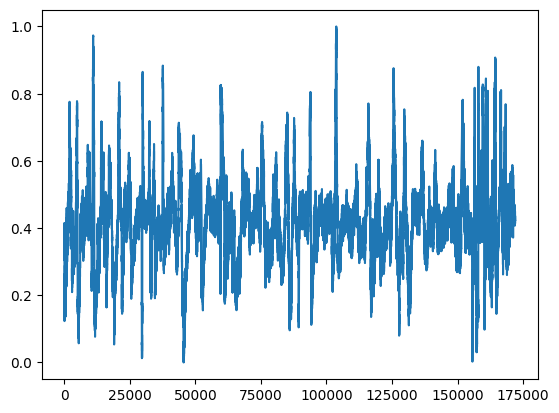

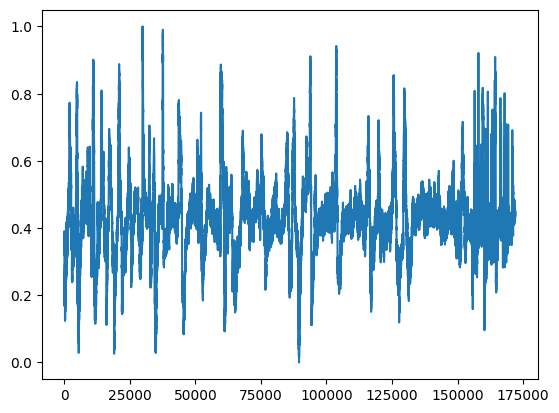

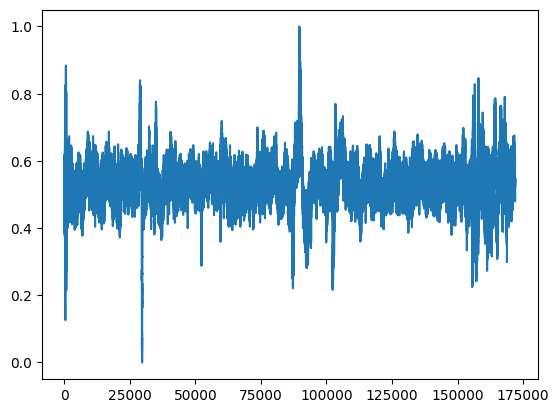

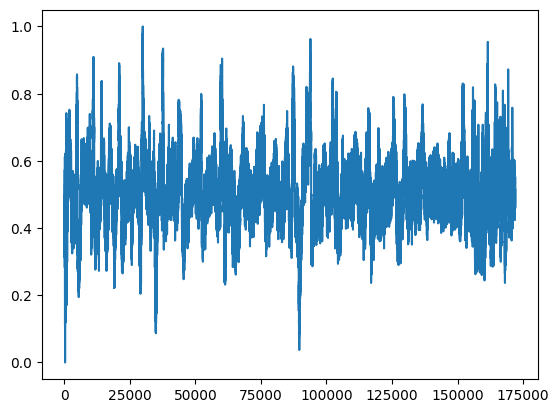

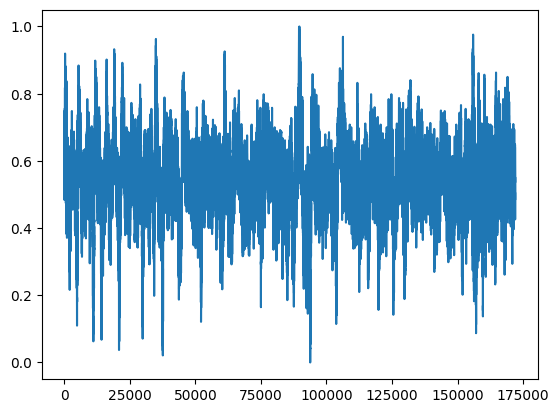

In [36]:
import pyedflib
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import joblib

# Creating a MinMaxScaler object
scaler = MinMaxScaler()

# Get the directory where the script is located
script_dir = os.getcwd()

# Construct the full path to the file
file_path = os.path.join(script_dir, 'EDF', 'short.edf')
signalList = []
signalListNorm = []
f = pyedflib.EdfReader(file_path)
n = f.signals_in_file
n=n-14
signal_labels = f.getSignalLabels()
sample_f = f.getSampleFrequencies()
number_of_samples = f.getNSamples()[0]
Nblocks = int(number_of_samples/64)
sigbufs = np.zeros(number_of_samples)
full_data64 = np.ndarray(shape=(Nblocks*n, 64, 1))
for i in np.arange(n):
        sigbufs[:] = f.readSignal(i, digital=False)
        signalList.append(sigbufs[:].reshape(-1, 1))
        # Normalizing the list  
        signalListNorm.append(scaler.fit_transform(signalList[i]))
        for j in np.arange(Nblocks):
                full_data64[i*Nblocks+j] = signalListNorm[i][j*64:(j+1)*64]
train_data, test_data = train_test_split(full_data64, test_size=0.1, random_state=42)
joblib.dump(scaler, 'scaler.pkl') #save the normalisation parameters for running inference
f.close()
print(train_data.shape, test_data.shape)
for i in np.arange(5):
        plt.figure(i+1)
        plt.plot(signalListNorm[i])
plt.show()

Training data, n=64,16-bit unsigned integer

In [24]:
import pyedflib
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

#Samples are represented in 16-bit 2's complement

# Get the directory where the script is located
script_dir = os.getcwd()

# Construct the full path to the file
file_path = os.path.join(script_dir, 'EDF', 'short.edf')
signalList = []
f = pyedflib.EdfReader(file_path)
n = f.signals_in_file
n=n-14
signal_labels = f.getSignalLabels()
sample_f = f.getSampleFrequencies()
number_of_samples = f.getNSamples()[0]
Nblocks = int(number_of_samples/64)
sigbufs = np.zeros(number_of_samples)
full_data64 = np.ndarray(shape=(Nblocks*n, 64, 1))
X = np.zeros(n*number_of_samples)
for i in np.arange(n):
        sigbufs[:] = f.readSignal(i, digital=True)
        #sigbufs_new = (sigbufs + 32678)/(2**16-1) #normalised
        sigbufs_new = (sigbufs + 32678) #converts 16-bit 2's complement to 16-bit unsigned integer
        signalList.append(sigbufs_new) 
        X[i*number_of_samples:(i+1)*number_of_samples] = sigbufs[:]
        for j in np.arange(Nblocks):
                full_data64[i*Nblocks+j] = signalList[i][j*64:(j+1)*64].reshape(64, 1)
train_data, test_data = train_test_split(full_data64, test_size=0.1, random_state=42)
print(train_data.shape, test_data.shape)
f.close()

(50784, 64, 1) (5643, 64, 1)


32x32 Multichannel Data

In [29]:
import pyedflib
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import joblib


# Creating a MinMaxScaler object
scaler = MinMaxScaler()

# Get the directory where the script is located
script_dir = os.getcwd()

# Construct the full path to the file
file_path = os.path.join(script_dir, 'EDF', 'short.edf')
signalList = []
signalListNorm = []
f = pyedflib.EdfReader(file_path)
n = f.signals_in_file
n=n-3
signal_labels = f.getSignalLabels()
sample_f = f.getSampleFrequencies()
number_of_samples = f.getNSamples()[0]
Nblocks = int(number_of_samples/32)
sigbufs = np.zeros(number_of_samples)
full_data32 = np.ndarray(shape=(Nblocks, 32, 32))
X = np.zeros(n*number_of_samples)
for i in np.arange(n):
        sigbufs[:] = f.readSignal(i, digital=False)
        signalList.append(f.readSignal(i, digital=False))
        # Normalizing the list  
        X[i*number_of_samples:(i+1)*number_of_samples] = sigbufs[:]
        signalListNorm.append(scaler.fit_transform(sigbufs[:].reshape(-1, 1)))
        for j in np.arange(Nblocks):
                full_data32[j][i] = signalListNorm[i][j*32:(j+1)*32].reshape(32,)
train_data, test_data = train_test_split(full_data32, test_size=0.1, random_state=42)
joblib.dump(scaler, 'scaler.pkl') #save the normalisation parameters for running inference
print(n)
f.close()
print(train_data.shape, test_data.shape)

32
(4837, 32, 32) (538, 32, 32)


PRD Loss Definition


In [37]:
import tensorflow as tf
def prd_loss(y_true, y_pred):
    rms_deviation = (tf.reduce_sum(tf.square(y_true - y_pred)))
    percentage_rmsd = tf.sqrt(rms_deviation/(tf.reduce_sum(tf.square(y_true))+tf.keras.backend.epsilon()))* 100
    return percentage_rmsd

In [67]:
import tensorflow as tf
def prd_loss(y_true, y_pred):
    mse = tf.reduce_sum(tf.square(y_true - y_pred))
    percentage_rmsd = tf.sqrt(mse / (tf.reduce_sum(tf.square(y_true))))*100
    return percentage_rmsd

In [34]:
a = np.array([1., 2., 3.])
a_pred = np.array([3., 4., 5.])
loss = prd_loss(a, a_pred)
aaa = (12/14)**(0.5)
print(loss, aaa)

tf.Tensor(0.9258200997725514, shape=(), dtype=float64) 0.9258200997725514


Simple Model with CR=4, PRD=5.5% (Normalised)


In [8]:
import keras
from keras import models
from keras import layers


# Define the encoder
input_ts = layers.Input(shape=(64, 1), name="input_time_series")#64,1
x = layers.Conv1D(16, 3, activation='relu', padding='same')(input_ts)#64,16
x = layers.MaxPooling1D(2, padding='same')(x)  # 32,16
x = layers.Conv1D(8, 3, activation='relu', padding='same')(x)#32,8
x = layers.MaxPooling1D(2, padding='same')(x)  # 16,8
#x = layers.Conv1D(1, 3, activation='relu', padding='same')(x)  # Reduce to single filter
#encoded = layers.MaxPooling1D(2, padding='same')(x)  # Ensure output shape is (16, 1)
x = layers.Dense(16, activation='relu')(x) #16,16
encoded = layers.Conv1D(1, 3, activation='relu', padding='same')(x) #16,1
encoder = models.Model(input_ts, encoded, name="encoder")

# Define the decoder
encoded_input = layers.Input(shape=(16, 1), name="encoded_input")#16,1
x = layers.Conv1D(16, 3, activation='relu', padding='same')(encoded_input)#16,16
x = layers.Dense(8, activation='relu')(x)#16,8
x = layers.UpSampling1D(2)(x)  # 32,8
x = layers.Conv1D(16, 3, activation='relu', padding='same')(x) #32,16
x = layers.UpSampling1D(2)(x)  # 64,16
decoded = layers.Conv1D(1, 3, activation='sigmoid', padding='same')(x) #64,1

decoder = models.Model(encoded_input, decoded, name="decoder")

# Define the autoencoder
autoencoder_input = layers.Input(shape=(64, 1), name="autoencoder_input")
encoded_ts = encoder(autoencoder_input)
decoded_ts = decoder(encoded_ts)

autoencoder = models.Model(autoencoder_input, decoded_ts, name="autoencoder")

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss=prd_loss, metrics=['mse'])

# Summary of the autoencoder
autoencoder.summary()

# Train the autoencoder
history = autoencoder.fit(train_data, train_data, epochs=20, batch_size=64, shuffle=True, validation_split=0.2)

# Save the encoder and decoder
encoder.save("encoder_model.h5")
decoder.save("decoder_model.h5")


Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 autoencoder_input (InputLa  [(None, 64, 1)]           0         
 yer)                                                            
                                                                 
 encoder (Functional)        (None, 16, 1)             649       
                                                                 
 decoder (Functional)        (None, 64, 1)             649       
                                                                 
Total params: 1298 (5.07 KB)
Trainable params: 1298 (5.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
968/968 [==============================] - 6s 5ms/step - loss: 9.8963 - mse: 0.0030 - val_loss: 7.2420 - val_mse: 0.0013
Epoch 2/20
968/968 [==============================] - 5s 5ms/step - loss: 7.0382 - mse: 0

Model for n=64, cr=8, 16-bit integer


In [26]:
import keras
from keras import models
from keras import layers
import numpy as np

# Define the encoder
input_ts = layers.Input(shape=(64, 1), name="input_time_series") # 64, 1
x = layers.Conv1D(16, 3, activation='linear', padding='same')(input_ts) # 64, 16
x = layers.MaxPooling1D(2, padding='same')(x)  # 32, 16
x = layers.Conv1D(8, 3, activation='relu', padding='same')(x) # 32, 8
x = layers.MaxPooling1D(2, padding='same')(x)  # 16, 8
x = layers.Conv1D(4, 3, activation='relu', padding='same')(x) # 16, 4
x = layers.Flatten()(x) # Flatten for Dense layer
encoded = layers.Dense(8, activation='relu')(x) # 8
encoder = models.Model(input_ts, encoded, name="encoder")

# Define the decoder
encoded_input = layers.Input(shape=(8,), name="encoded_input") # 8
x = layers.Dense(16 * 4, activation='relu')(encoded_input) # 16 * 4
x = layers.Reshape((16, 4))(x) # Reshape back to (16, 4)
x = layers.Conv1D(8, 3, activation='relu', padding='same')(x) # 16, 8
x = layers.UpSampling1D(2)(x)  # 32, 8
x = layers.Conv1D(16, 3, activation='relu', padding='same')(x) # 32, 16
x = layers.UpSampling1D(2)(x)  # 64, 16
decoded = layers.Conv1D(1, 3, activation='linear', padding='same')(x) # 64, 1

decoder = models.Model(encoded_input, decoded, name="decoder")

# Define the autoencoder
autoencoder_input = layers.Input(shape=(64, 1), name="autoencoder_input")
encoded_ts = encoder(autoencoder_input)
decoded_ts = decoder(encoded_ts)

autoencoder = models.Model(autoencoder_input, decoded_ts, name="autoencoder")

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss=prd_loss, metrics=['mse'])

# Summary of the autoencoder
autoencoder.summary()

# Train the autoencoder
history = autoencoder.fit(train_data, train_data, epochs=20, batch_size=64, shuffle=True, validation_split=0.2)

# Save the encoder and decoder
encoder.save("encoder_model.h5")
decoder.save("decoder_model.h5")


Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 autoencoder_input (InputLa  [(None, 64, 1)]           0         
 yer)                                                            
                                                                 
 encoder (Functional)        (None, 8)                 1076      
                                                                 
 decoder (Functional)        (None, 64, 1)             1129      
                                                                 
Total params: 2205 (8.61 KB)
Trainable params: 2205 (8.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
635/635 [==============================] - 6s 7ms/step - loss: 10.0253 - mse: 78141416.0000 - val_loss: 0.3283 - val_mse: 11556.2803
Epoch 2/20
635/635 [==============================] - 4s 7ms/step - loss: 0.4

c:\Users\berkb\anaconda3\envs\keras_env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


89/89 [==============================] - 0s 2ms/step


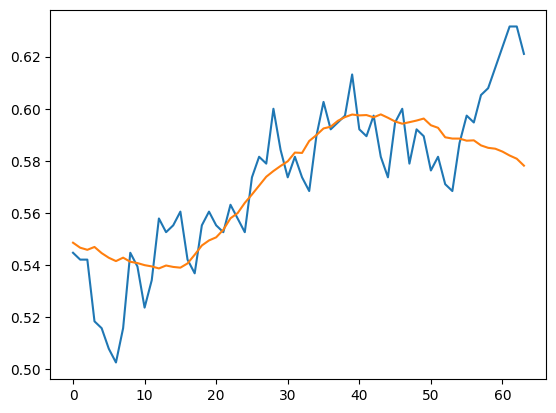

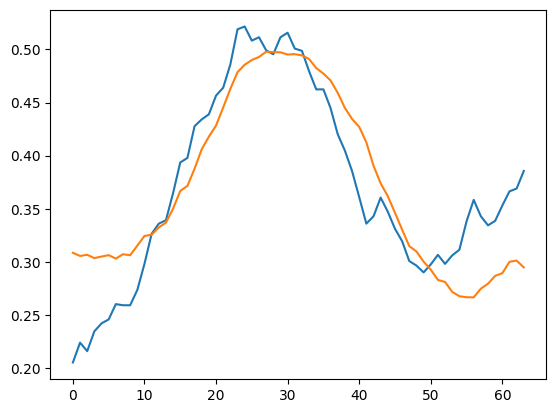

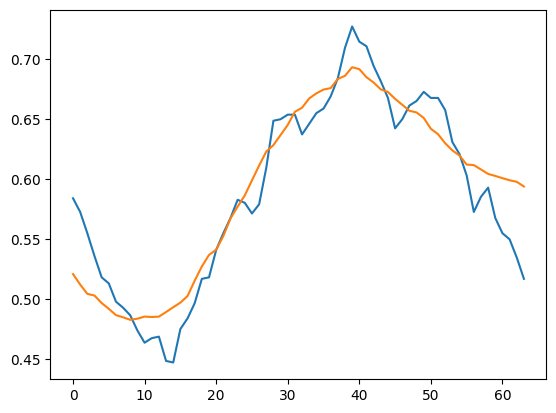

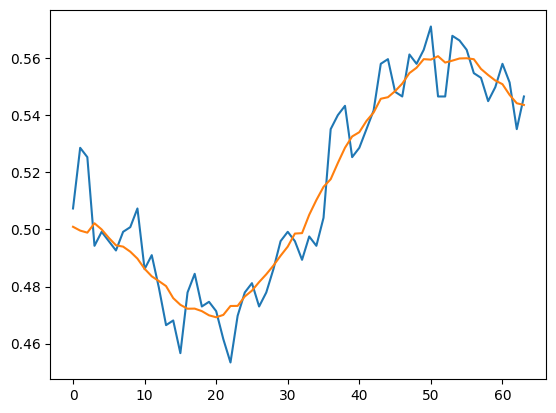

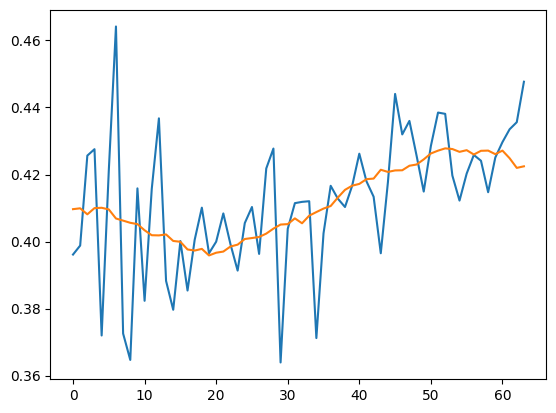

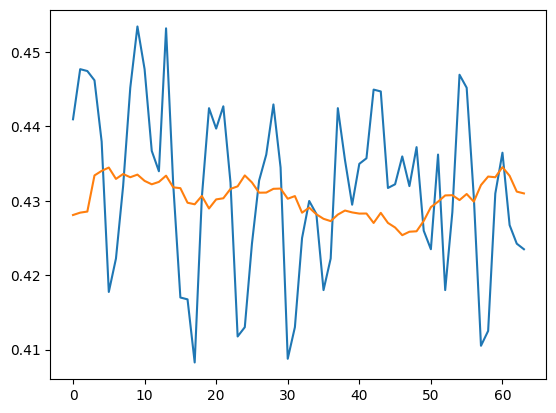

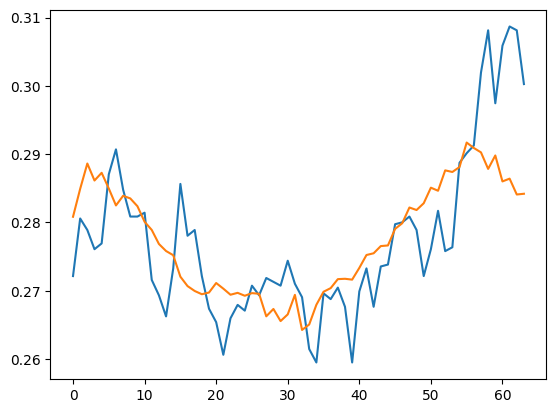

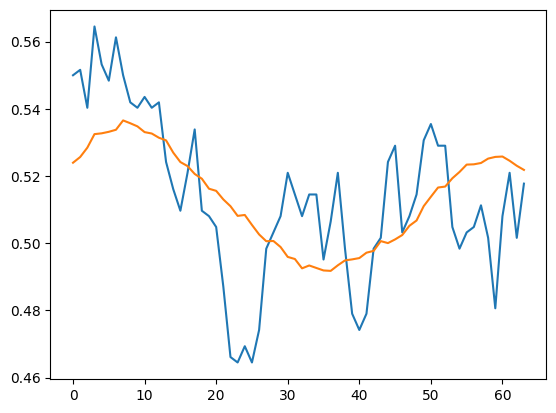

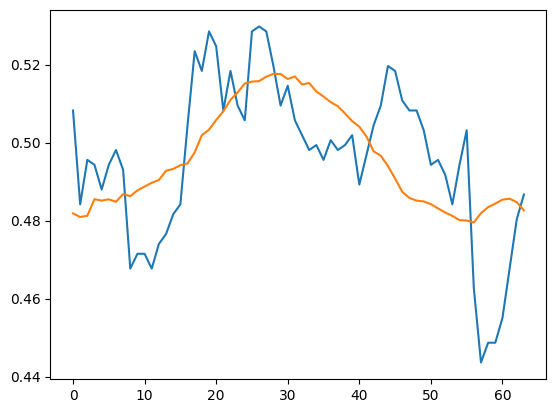

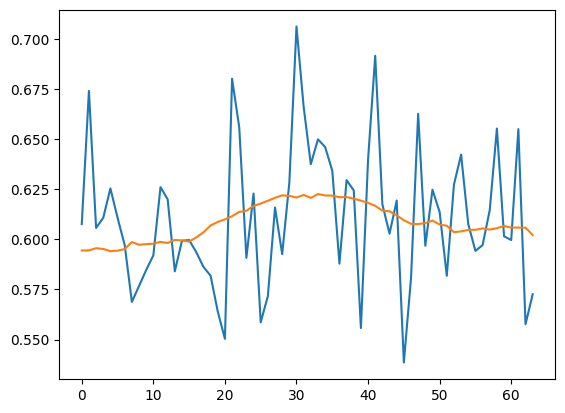

In [39]:
predicted_test = autoencoder.predict(x=test_data, batch_size=64)
for i in np.arange(10):
    plt.figure(i)
    plt.plot(test_data[i])
    plt.plot(predicted_test[i])

32x32 Multichannel Input, CR=16, PRD=11.8%

In [38]:
import keras
from keras import layers, models
import numpy as np

# Define the encoder
input_data = layers.Input(shape=(32, 32, 1), name="input_data")
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_data)
x = layers.MaxPooling2D((2, 2), padding='same')(x)  # 32x32 -> 16x16
x = layers.Conv2D(8, (5, 5), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)  # 16x16 -> 8x8
x = layers.Conv2D(1, (3, 3), activation='relu', padding='same')(x)  # Reduce to single filter
encoded = layers.Reshape((64, 1))(x)  #  to shape (64, 1)

encoder = models.Model(input_data, encoded, name="encoder")

# Define the decoder
encoded_input = layers.Input(shape=(64, 1), name="encoded_input")  # 64, 1
x = layers.Reshape((8, 8, 1))(encoded_input)  # Reshape back to (8, 8, 1)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)  # 8x8 -> 16x16
x = layers.Conv2D(16, (5, 5), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)  # 16x16 -> 32x32
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)  # 32x32

decoder = models.Model(encoded_input, decoded, name="decoder")

# Define the autoencoder
autoencoder_input = layers.Input(shape=(32, 32, 1), name="autoencoder_input")
encoded_data = encoder(autoencoder_input)
decoded_data = decoder(encoded_data)

autoencoder = models.Model(autoencoder_input, decoded_data, name="autoencoder")

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss=prd_loss, metrics=['mse'])

# Summary of the autoencoder
autoencoder.summary()

# Train the autoencoder
history = autoencoder.fit(train_data, train_data, epochs=40, batch_size=64, shuffle=True, validation_split=0.2)

# Save the encoder and decoder
encoder.save("encoder_model.h5")
decoder.save("decoder_model.h5")


Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 autoencoder_input (InputLa  [(None, 32, 32, 1)]       0         
 yer)                                                            
                                                                 
 encoder (Functional)        (None, 64, 1)             3441      
                                                                 
 decoder (Functional)        (None, 32, 32, 1)         3441      
                                                                 
Total params: 6882 (26.88 KB)
Trainable params: 6882 (26.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/40
61/61 [==============================] - 4s 57ms/step - loss: 26.3626 - mse: 0.0171 - val_loss: 22.6490 - val_mse: 0.0125
Epoch 2/40
61/61 [==============================] - 3s 56ms/step - loss: 20.5804 - mse

c:\Users\berkb\anaconda3\envs\keras_env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [51]:
import keras
from keras import layers, models
import numpy as np

# Define the encoder
input_data = layers.Input(shape=(32, 32, 1), name="input_data")
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_data)
x = layers.MaxPooling2D((2, 2), padding='same')(x)  # 32x32 -> 16x16
x = layers.Conv2D(8, (5, 5), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)  # 16x16 -> 8x8
x = layers.Conv2D(2, (3, 3), activation='relu', padding='same')(x)  # Reduce to double filter
encoded = layers.Reshape((128, 1))(x)  #  to shape (128, 1)

encoder = models.Model(input_data, encoded, name="encoder")

# Define the decoder
encoded_input = layers.Input(shape=(128, 1), name="encoded_input")  # 128, 1
x = layers.Reshape((8, 8, 2))(encoded_input)  # Reshape back to (8, 8, 2)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)  # 8x8 -> 16x16
x = layers.Conv2D(16, (5, 5), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)  # 16x16 -> 32x32
decoded = layers.Conv2D(1, (3, 3), activation='relu', padding='same')(x)  # 32x32

decoder = models.Model(encoded_input, decoded, name="decoder")

# Define the autoencoder
autoencoder_input = layers.Input(shape=(32, 32, 1), name="autoencoder_input")
encoded_data = encoder(autoencoder_input)
decoded_data = decoder(encoded_data)

autoencoder = models.Model(autoencoder_input, decoded_data, name="autoencoder")

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss=prd_loss, metrics=['mse'])

# Summary of the autoencoder
autoencoder.summary()

# Train the autoencoder
history = autoencoder.fit(train_data, train_data, epochs=40, batch_size=64, shuffle=True, validation_split=0.2)

# Save the encoder and decoder
encoder.save("encoder_model.h5")
decoder.save("decoder_model.h5")


Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 autoencoder_input (InputLa  [(None, 32, 32, 1)]       0         
 yer)                                                            
                                                                 
 encoder (Functional)        (None, 128, 1)            3514      
                                                                 
 decoder (Functional)        (None, 32, 32, 1)         3513      
                                                                 
Total params: 7027 (27.45 KB)
Trainable params: 7027 (27.45 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/40
61/61 [==============================] - 4s 58ms/step - loss: 87.4282 - mse: 2995.5515 - val_loss: 75.7938 - val_mse: 2208.4329
Epoch 2/40
61/61 [==============================] - 4s 60ms/step - loss: 73.0996

CR=8, N=64 PRD=6.2%

In [38]:
import keras
from keras import models
from keras import layers
import numpy as np

# Define the encoder
input_ts = layers.Input(shape=(64, 1), name="input_time_series") # 64, 1
x = layers.Conv1D(16, 3, activation='relu', padding='same')(input_ts) # 64, 16
x = layers.MaxPooling1D(2, padding='same')(x)  # 32, 16
x = layers.Conv1D(8, 3, activation='relu', padding='same')(x) # 32, 8
x = layers.MaxPooling1D(2, padding='same')(x)  # 16, 8
x = layers.Conv1D(4, 3, activation='relu', padding='same')(x) # 16, 4
x = layers.Flatten()(x) # Flatten for Dense layer
encoded = layers.Dense(8, activation='relu')(x) # 8
encoder = models.Model(input_ts, encoded, name="encoder")

# Define the decoder
encoded_input = layers.Input(shape=(8,), name="encoded_input") # 8
x = layers.Dense(16 * 4, activation='relu')(encoded_input) # 16 * 4
x = layers.Reshape((16, 4))(x) # Reshape back to (16, 4)
x = layers.Conv1D(8, 3, activation='relu', padding='same')(x) # 16, 8
x = layers.UpSampling1D(2)(x)  # 32, 8
x = layers.Conv1D(16, 3, activation='relu', padding='same')(x) # 32, 16
x = layers.UpSampling1D(2)(x)  # 64, 16
decoded = layers.Conv1D(1, 3, activation='sigmoid', padding='same')(x) # 64, 1

decoder = models.Model(encoded_input, decoded, name="decoder")

# Define the autoencoder
autoencoder_input = layers.Input(shape=(64, 1), name="autoencoder_input")
encoded_ts = encoder(autoencoder_input)
decoded_ts = decoder(encoded_ts)

autoencoder = models.Model(autoencoder_input, decoded_ts, name="autoencoder")

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss=prd_loss, metrics=['mse'])

# Summary of the autoencoder
autoencoder.summary()

# Train the autoencoder
history = autoencoder.fit(train_data, train_data, epochs=20, batch_size=64, shuffle=True, validation_split=0.2)

# Save the encoder and decoder
encoder.save("encoder_model.h5")
decoder.save("decoder_model.h5")


Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 autoencoder_input (InputLa  [(None, 64, 1)]           0         
 yer)                                                            
                                                                 
 encoder (Functional)        (None, 8)                 1076      
                                                                 
 decoder (Functional)        (None, 64, 1)             1129      
                                                                 
Total params: 2205 (8.61 KB)
Trainable params: 2205 (8.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
635/635 [==============================] - 5s 6ms/step - loss: 8.2989 - mse: 0.0023 - val_loss: 5.5790 - val_mse: 7.4294e-04
Epoch 2/20
635/635 [==============================] - 4s 6ms/step - loss: 5.4728 - ms

c:\Users\berkb\anaconda3\envs\keras_env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [87]:
print((autoencoder.evaluate(test_data, test_data)))

177/177 [==============================] - 0s 2ms/step - loss: 0.5536 - mse: 32783.3438
[0.5535868406295776, 32783.34375]


In [1]:
import tensorflow as tf 
print(tf.config.list_physical_devices('GPU'))


[]
